## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 4 февраля 2025**

**Дедлайн: 12 февраля 2025 23:59 MSK**

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

%matplotlib inline

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре.

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [ ]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [ ]:
df.shape

(5476250, 5)

In [ ]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
5317646,766216,12184,91,2744,51.0
853403,292518,13543,144,109,2.0
3945113,498220,4151,140,30315,100.0
1337667,388923,4927,98,6284,91.0
2766832,292078,4151,162,4854,38.0


Сделаем разбиение по времени

<Axes: >

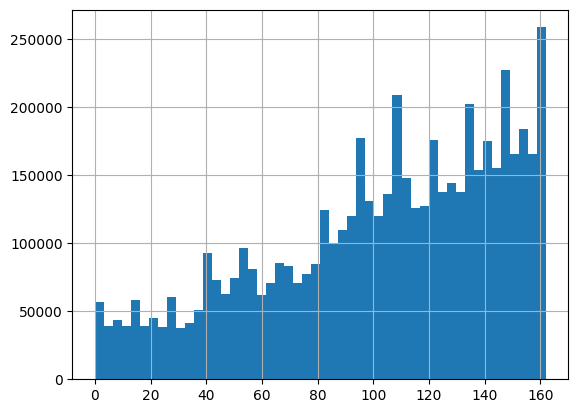

In [ ]:
df.last_watch_dt.hist(bins=50)

In [ ]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [ ]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [ ]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [ ]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
123,514235,8391,147,3570,57.0
131,470881,11800,100,909,19.0
186,450102,3130,85,682,9.0
207,170430,12148,66,111,0.0
234,20224,8650,102,154,3.0


In [ ]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

<ipython-input-86-2ac47bd011f3>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(
<ipython-input-86-2ac47bd011f3>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


,user_id,train_interactions
0,165,"[(12173, 122)]"
1,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ..."
2,400,"[(169, 144), (11047, 145), (12974, 145), (1399..."
3,446,"[(13865, 105)]"
4,515,"[(3734, 114), (9728, 114), (4457, 115), (13865..."


In [ ]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,165,"[(12173, 122)]","[(4969, 161)]"
1,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ...","[(4651, 155), (15384, 155), (11099, 157), (633..."
2,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]"
3,446,"[(13865, 105)]","[(12202, 160), (230, 160)]"
4,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,..."


In [ ]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,165,"[(12173, 122)]","[(4969, 161)]","[10639, 16448, 1988]"
1,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ...","[(4651, 155), (15384, 155), (11099, 157), (633...","[10639, 16448, 1988]"
2,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]","[10639, 16448, 1988]"
3,446,"[(13865, 105)]","[(12202, 160), (230, 160)]","[10639, 16448, 1988]"
4,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,...","[10639, 16448, 1988]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$.

In [ ]:
def ap_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn is None:
        topn = len(predictions)

    indices = np.arange(len(predictions[:topn])) + 1
    relevant = np.isin(predictions[:topn], gt_items).astype(int)

    precision = np.cumsum(relevant) / indices
    ap_metric = np.sum(relevant * precision)/min(len(gt_items), topn)

    return ap_metric


def rr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn is None:
        topn = len(predictions)

    rank = np.where(np.isin(predictions[:topn], gt_items))[0]
    rr_metric = 1.0 / (rank[0] + 1) if len(rank) > 0 else 0.0

    return rr_metric


def hr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn is None:
        topn = len(predictions)

    hr = np.isin(predictions[:topn], gt_items).astype(int)
    hr_metric = np.sum(hr) > 0

    return int(hr_metric)

Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит.

In [ ]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать.

In [ ]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [ ]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 6.666666666666666e-05, 'mrr': 0.0001, 'hr': 0.0002}

In [ ]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,165,"[(12173, 122)]","[(4969, 161)]","[10639, 16448, 1988]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
1,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ...","[(4651, 155), (15384, 155), (11099, 157), (633...","[10639, 16448, 1988]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
2,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]","[10639, 16448, 1988]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
3,446,"[(13865, 105)]","[(12202, 160), (230, 160)]","[10639, 16448, 1988]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
4,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,...","[10639, 16448, 1988]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [ ]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.07034308560090702, 'mrr': 0.1234938492063492, 'hr': 0.3066}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [ ]:
class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions'):
        counts = {}

        for _, row in df.iterrows():
            for item, day in row[col]:
                if day >= 152 - self.min_window:
                    if item in counts:
                        counts[item] += 1
                    else:
                        counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)

In [ ]:
toppopweighted = TopPopularWeighted()
toppopweighted.fit(joined)

joined['TopPopularWeighted_recs'] = toppopweighted.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,TopPopularWeighted_recs
0,165,"[(12173, 122)]","[(4969, 161)]","[10639, 16448, 1988]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 7793, 341, 13865, 12192, ..."
1,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ...","[(4651, 155), (15384, 155), (11099, 157), (633...","[10639, 16448, 1988]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 7793, 341, 13865, 12192, ..."
2,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]","[10639, 16448, 1988]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 7793, 341, 13865, 12192, ..."
3,446,"[(13865, 105)]","[(12202, 160), (230, 160)]","[10639, 16448, 1988]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 7793, 341, 13865, 12192, ..."
4,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,...","[10639, 16448, 1988]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 7793, 341, 13865, 12192, ..."


Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна.

In [ ]:
evaluate_recommender(joined, model_preds='TopPopularWeighted_recs')

{'map': 0.0729172022707231, 'mrr': 0.12664738095238096, 'hr': 0.3296}

In [ ]:
%%time

map_metrics_window, mrr_metrics_window, hr_metrics_window = [], [], []

for k in range(1, 101):

    toppopweighted = TopPopularWeighted(min_window=k)
    toppopweighted.fit(joined)

    joined['toppopweighted_recs'] = toppopweighted.predict(joined)

    metrics_window = evaluate_recommender(joined, model_preds='toppopweighted_recs')
    map_metrics_window.append(metrics_window['map'])
    mrr_metrics_window.append(metrics_window['mrr'])
    hr_metrics_window.append(metrics_window['hr'])

CPU times: user 4min 9s, sys: 4.62 s, total: 4min 13s
Wall time: 4min 12s


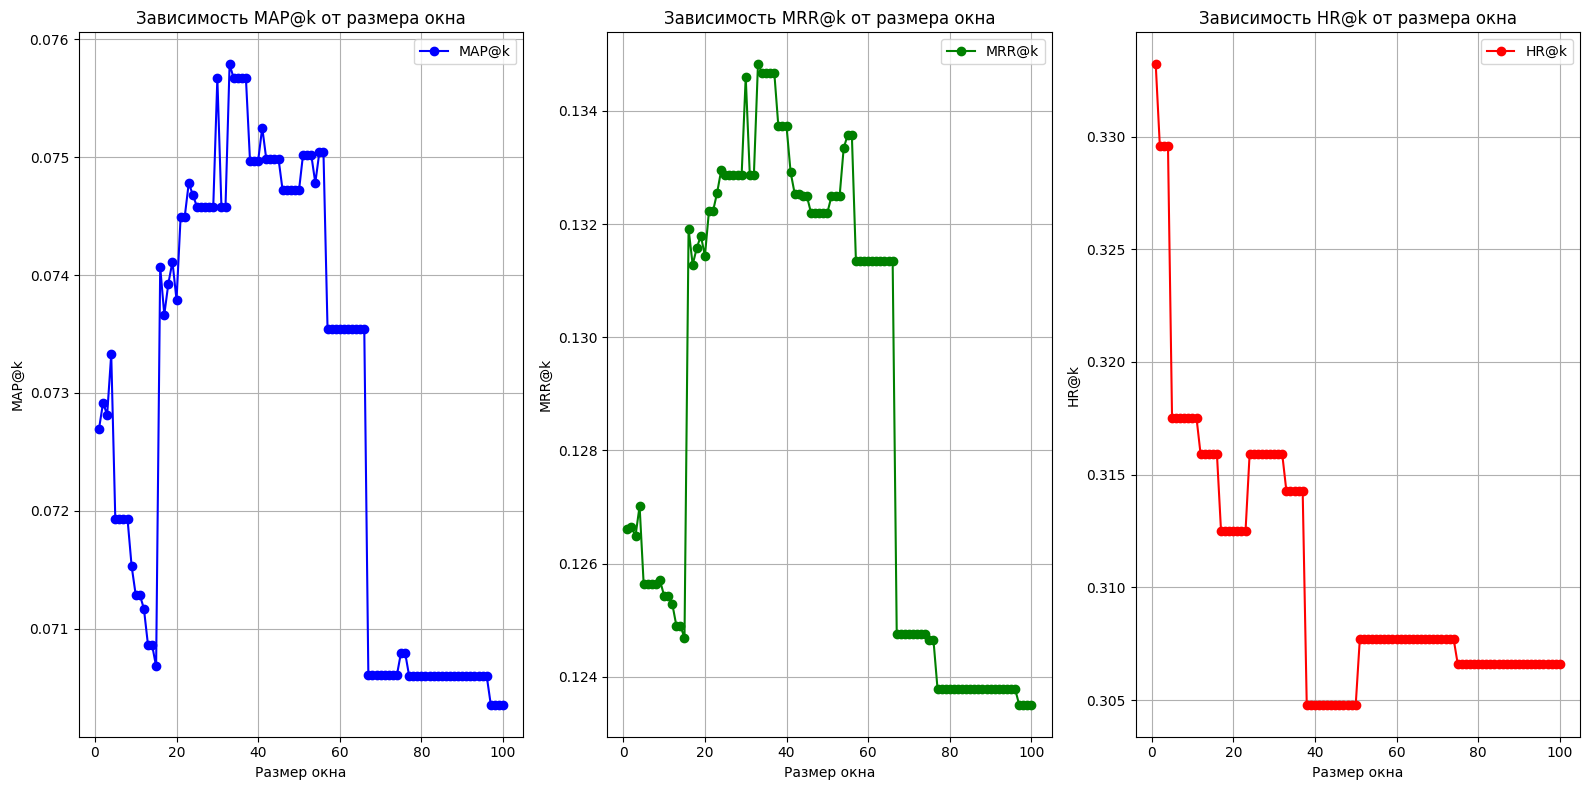

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8))
x = np.arange(1, 101, 1)

axs[0].plot(x, map_metrics_window, color='b', marker='o', linestyle='-', label='MAP@k')
axs[0].set_title('Зависимость MAP@k от размера окна')
axs[0].set_xlabel('Размер окна')
axs[0].set_ylabel('MAP@k')
axs[0].legend()
axs[0].grid()

axs[1].plot(x, mrr_metrics_window, color='g', marker='o', linestyle='-', label='MRR@k')
axs[1].set_title('Зависимость MRR@k от размера окна')
axs[1].set_xlabel('Размер окна')
axs[1].set_ylabel('MRR@k')
axs[1].legend()
axs[1].grid()

axs[2].plot(x, hr_metrics_window, color='r', marker='o', linestyle='-', label='HR@k')
axs[2].set_title('Зависимость HR@k от размера окна')
axs[2].set_xlabel('Размер окна')
axs[2].set_ylabel('HR@k')
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()

Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:** Изменение размера окна на более короткий временной интервал, то есть рекомендации на основе последних двух дней, привело к улучшению всех показателей. Это подчёркивает важность выбора правильного временного окна для рекомендаций, поскольку это повышает качество прогнозов. Чтобы определить оптимальное значение временного окна, необходимо провести тщательный анализ данных и изучить тренды. Не имеет смысла брать слишком большое окно, так как тогда система будет учитывать слишком много информации, включая те взаимодействия, которые уже потеряли актуальность. Также не имеет смысла брать слишком маленькое окно, ведь тогда система будет учитывать лишь ограниченное число предыдущих взаимодействий пользователей.

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике.

In [ ]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

In [ ]:
%%time

toppop = TopPopular()
toppop.fit(joined)
map_metrics, mrr_metrics, hr_metrics = [], [], []

for k in range(1, 101):

    joined['toppopular_recs'] = toppop.predict(joined, topn=k)

    metrics = evaluate_recommender(joined, model_preds='toppopular_recs')
    map_metrics.append(metrics['map'])
    mrr_metrics.append(metrics['mrr'])
    hr_metrics.append(metrics['hr'])

CPU times: user 3min 42s, sys: 3.53 s, total: 3min 46s
Wall time: 3min 44s


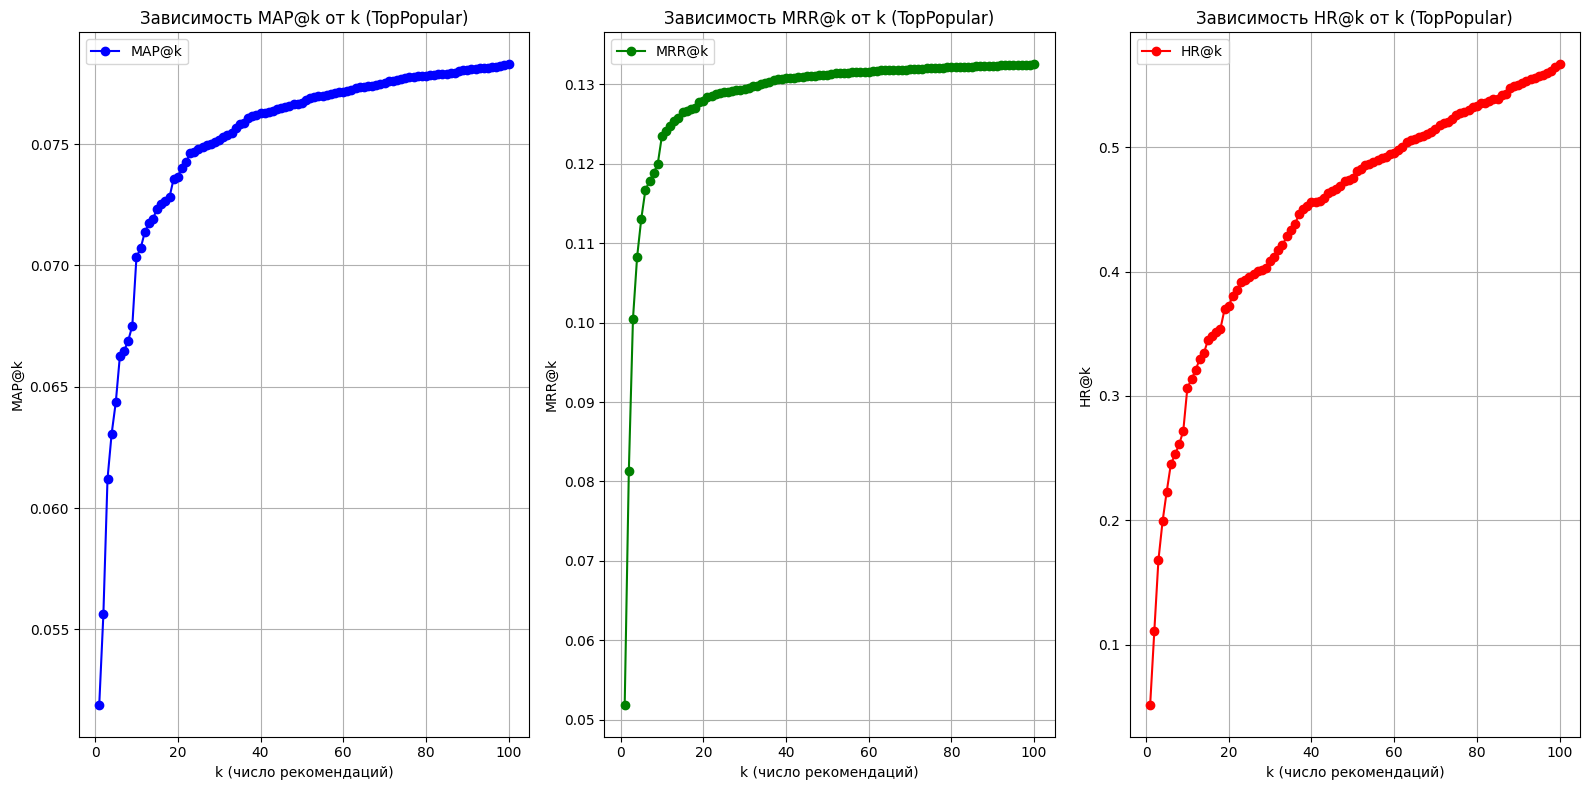

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8))
x = np.arange(1, 101, 1)

axs[0].plot(x, map_metrics, color='b', marker='o', linestyle='-', label='MAP@k')
axs[0].set_title('Зависимость MAP@k от k (TopPopular)')
axs[0].set_xlabel('k (число рекомендаций)')
axs[0].set_ylabel('MAP@k')
axs[0].legend()
axs[0].grid()

axs[1].plot(x, mrr_metrics, color='g', marker='o', linestyle='-', label='MRR@k')
axs[1].set_title('Зависимость MRR@k от k (TopPopular)')
axs[1].set_xlabel('k (число рекомендаций)')
axs[1].set_ylabel('MRR@k')
axs[1].legend()
axs[1].grid()

axs[2].plot(x, hr_metrics, color='r', marker='o', linestyle='-', label='HR@k')
axs[2].set_title('Зависимость HR@k от k (TopPopular)')
axs[2].set_xlabel('k (число рекомендаций)')
axs[2].set_ylabel('HR@k')
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:** По полученным графикам можно сделать вывод, что в рамках выбранного диапазона окна 1-100 все функции по top-k являются монотонными. Это можно объяснить тем, что чем больше айтемов мы будем рекомендовать, тем выше вероятность попасть в множество релевантных айтемов для каждого пользователя. Стоит отметить, что в среднем можно оставновитья на топ-30-50, так как после этого улучшение качества метрик становится менее значительным.

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей. \
**Ответ:**
 - График MAP@k: mean average precision @ k или средняя точность в топе k. Так как у нас более 100 фильмов, которые можно порекомендовать, то трудно уложиться в ~ 5 рекомендаций. Поэтому на графике мы видим резкий скачок метрики от 0.03 до 0.07 (рекомендуем 20 фильмов). После k=50 айтемов не имеет большого смысла предлагать новые фильмы - MAP@k слабо растет. Это можно объяснить тем, что пользователям не нужны рекомендации сотни фильмов для просмотра вечером, обычный пользователь хочет топ-30 фильмов на основе своих предпочтений, чтобы их было не мало и не много, но чтобы был выбор среди какого-то количества фильмов.

 - График MRR@k: метрика, связанная с позицией первого релеваннтого айтема среди первых k предсказаний. Как и MAP@k наблюдается резкий скачок с k=1 до k=20, но после этого качество растет сильно медленнее. Это можно объяснить тем, что скорее всего после того, как мы сформируем топ-20 или топ-30 рекомендуемых фильмов, среди рекомендаций найдется хоть один релевантный для пользователя фильм. Поэтому рекомендовать топ-100 не имеет смысла, ведь, как мы видим по графику, в среднем пользователям хватает топ-20 или топ-30 фильмов, так как среди них найдется хотя бы один, который им понравится.

 - График HR@k: среди первых k предсказаний есть хотя бы одно релевантное. Если предыдущая метрика была связана именно с позицией первого релевантного айтема и увеличение числа рекомендаций не давало улучшение метрики поскольку скорее всего релевантный фильм попадется в первых 30 предсказанных айтемов, то здесь мы имеем аналог accuracy. Если хотя бы один из предсказанных айтемов есть среди релевантных пользователю - то считается, что это успех. При этом заметно, что функция HR@k растет активнее остальных. Это можно объяснить тем, что чем больше мы рекламируем фильмов, тем сильнее мы повышаем вероятность того, что новый фильм окажется релевантен пользователю. Видно, что в среднем HR@k=0.5 при k=65 фильмов. То есть при рекомендации ~ 65 фильмов 50% пользователей среди топ-65 найдут ходя бы один релевантный фильм. Не очень-то хороший результат, хотелось бы, чтобы 85% пользователей находили бы свой фильм среди рекомендуемых топ-30.

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\
**Ответ:** Описание графиков и почему метрики так себя ведут описано во втором пункте. Конечно, графики должны возрастать, потому что при увеличении числа рекомендаций каждому пользователю, мы, как исследователи в области рекомендаций, облегчаем себе задачу тем, что расширяем множество возможных релевантных айтемов. Именно поэтому от k=1 до k=20 наблюдается сильный рост всех метрик, потому что очень трудно для каждого пользователя собрать рекомендации из 1-5 фильмов, так как шанс того, что мы попадем в релевантный фильм меньше, чем если бы мы могли порекомендовать 20-30 фильмов.

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей.

In [ ]:
items = pd.read_csv('items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

1917


<Axes: >

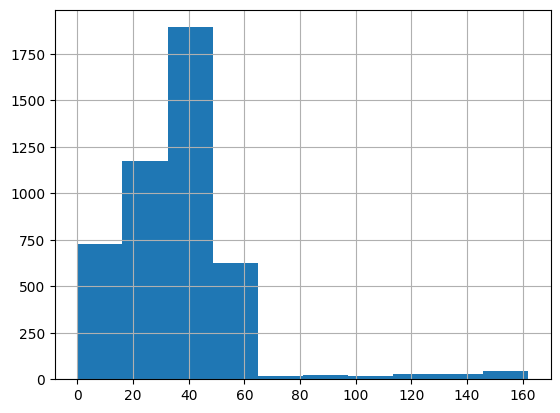

In [ ]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной.

Добавьте 5 своих примеров ниже. Опишите, как вы их искали.

In [ ]:
print(f'Максимальный id в датасете: {sorted(df.item_id.unique())[-1]}')

Максимальный id в датасете: 16518


Случайный роман, id: 13737


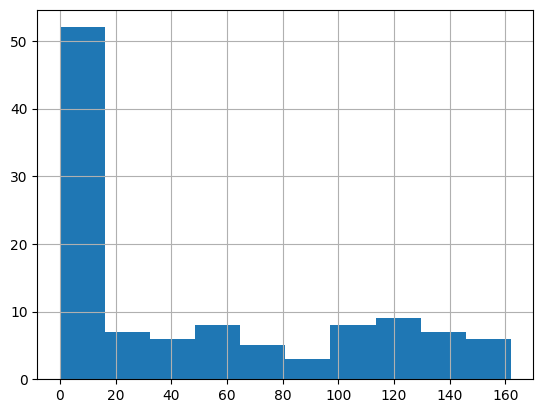

Монстры юга, id: 13762


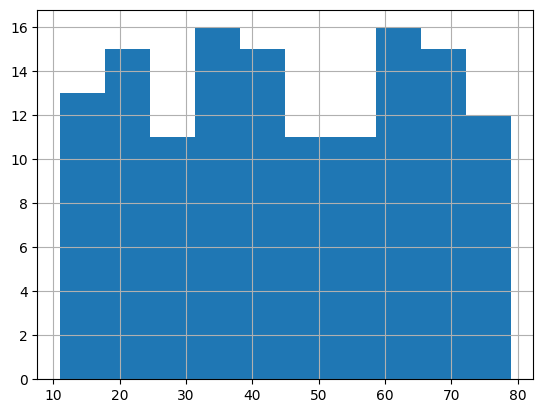

No such id
Жизнь задом наперед, id: 12151


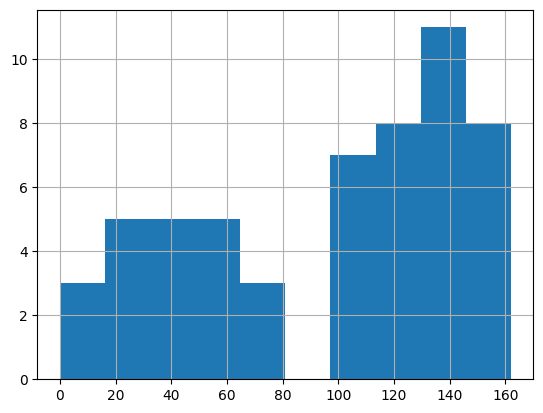

Золото Глории, id: 9616


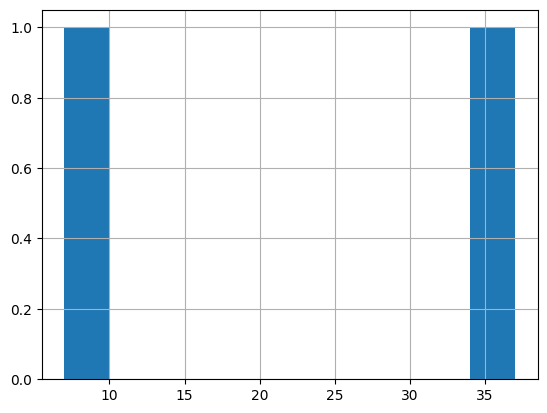

Опасный соблазн, id: 5760


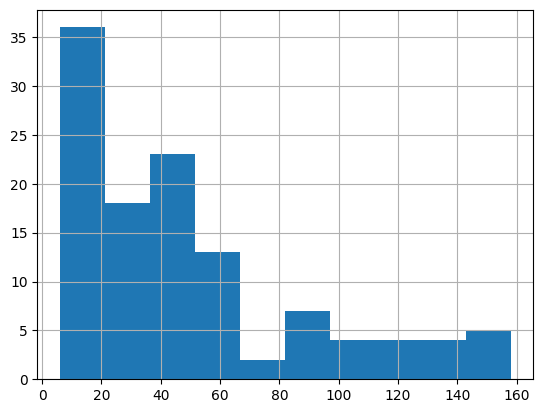

In [ ]:
for i in range(0, 101, 20):
    sampled_id = np.random.randint(0, 16519)
    interactions = df.loc[df.item_id==sampled_id].copy()
    try:
        name = items.loc[items.item_id==sampled_id].title.values[0]
        print(f'{name}, id: {sampled_id}')
        interactions.last_watch_dt.hist()
        plt.show()
    except:
        print('No such id')

Перебрав несколько графиков с распределениями я выбрал фильмы со следующими id: 0, 35, 70, 835, 16105

In [ ]:
import seaborn as sns

In [ ]:
def get_histplot(df, sampled_id, bins):
    interactions = df.loc[df.item_id==sampled_id].copy()
    name = items.loc[items.item_id==sampled_id].title.values[0]
    title = name + "; id: " + str(sampled_id)
    sns.histplot(interactions.last_watch_dt, color='sandybrown', bins=bins).set_title(title)
    plt.grid()
    plt.show()

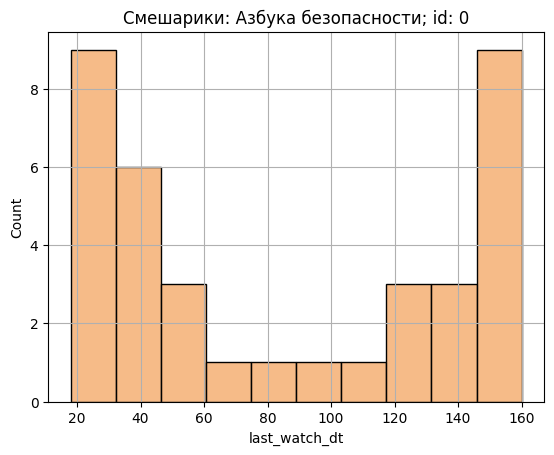

In [ ]:
get_histplot(df=df, sampled_id=0, bins=10)

Сериал "Смешарики: Азбука безопасности" в заданном интервале времени сначала пользовался большой популярностью, затем интерес к нему начал снижаться, но к концу выбранного периода популярность вновь возросла. Это можно объяснить тем, что сериал только появился на платформе, что вызвало первоначальный всплеск интереса. Со временем внимание зрителей стало угасать, однако рост популярности в конце периода может быть связан с выходом новой серии, которая привлекла зрителей снова.

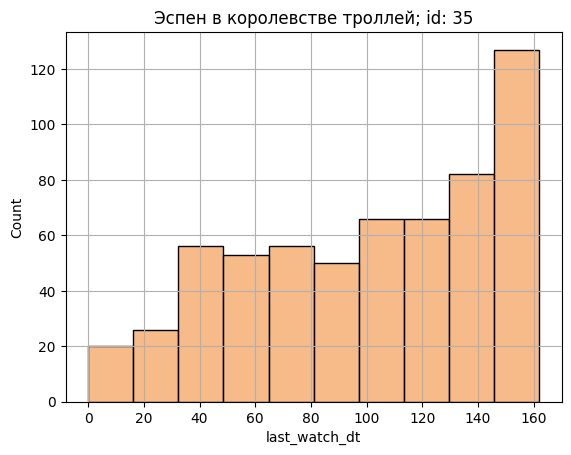

In [ ]:
get_histplot(df=df, sampled_id=35, bins=10)

Популярность фильма "Эспен в королевстве троллей" на протяжении всего рассматриваемого периода постепенно возрастала. Немного поисследовав, выяснилось, что это норвежский фильм. Учитывая, что я мало знаком с норвежскими фильмами и доля успешных норвежских фильмов в мировой кинематографии не так велика, можно предположить, что этот фильм не столь известен, как американские аналоги. Вероятно, о выходе фильма знали преимущественно в Норвегии, и он без значительных скачков постепенно набирал популярность, возможно и в других странах.

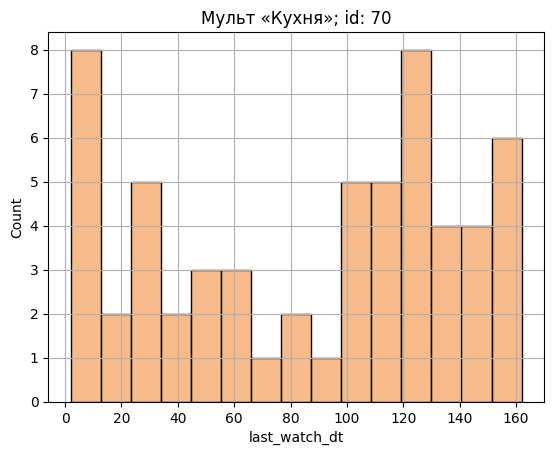

In [ ]:
get_histplot(df=df, sampled_id=70, bins=15)

"Мульт "Кухня"" - мультсериал, поэтому его распределение не имеет какой-то четкой структуры. Скорее всего колебания в количестве просмотров связаны с тем, что различные серии выходят достаточно часто и имеют разный уровень успеха: некоторые серии привлекают больше зрителей, в то время как другие получают меньше просмотров.

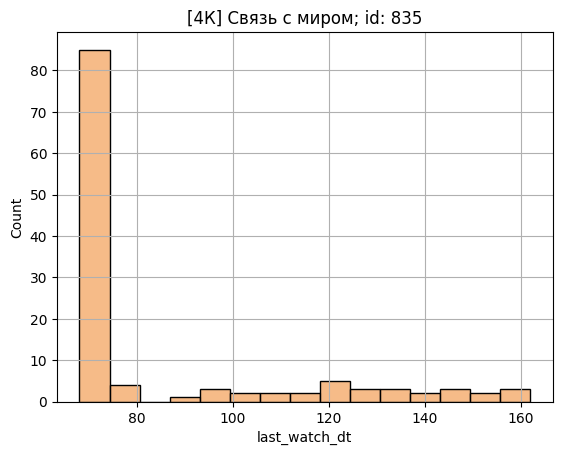

In [ ]:
get_histplot(df=df, sampled_id=835, bins=15)

Фильм "[4K] Связь с миром" сначала пользовался значительной популярностью, но затем его востребованность резко снизилась и практически упала до нуля. Это может быть связано с тем, что фильм был сильно ожидаем зрителями и сразу после выхода привлек большое внимание. Однако позже зрители могли переключиться на другой популярный фильм, вышедший вскоре после него. Также такой резкий перепад может, как было в примере, свидетельствовать и о возможном ограничении доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной.

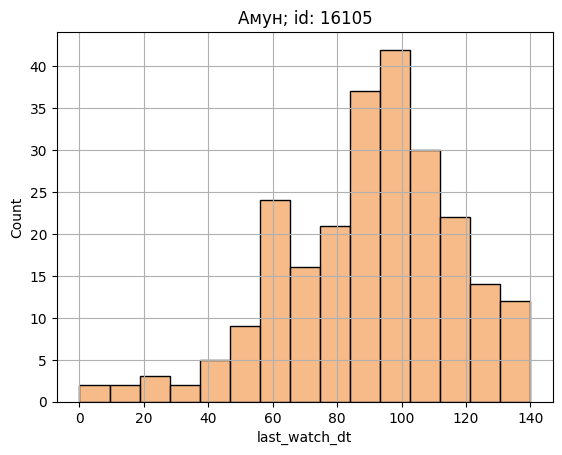

In [ ]:
get_histplot(df=df, sampled_id=16105, bins=15)

Фильм "Амун" постепенно набирает популярность, достигает своего пика и затем постепенно теряет популярность. Это, скорее всего, отражает стандартное развитие цикла популярности фильма, который не был ожидаемым к выходу. Если бы он был в списке ожидаемых, то в самом начале наблюдался бы большой пик популярности, который затем постепенно снижался.

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках.

In [ ]:
def filter_column(df, min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items
    """
    user_counts = df['user_id'].value_counts()
    item_counts = df['item_id'].value_counts()

    active_users = user_counts[user_counts >= min_freq].index
    popular_items = item_counts[item_counts >= min_freq].index

    filtered_df = df[df['user_id'].isin(active_users) & df['item_id'].isin(popular_items)]

    return filtered_df


def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe
    """
    filtered_df = df.copy()

    while True:
        prev_shape = filtered_df.shape
        filtered_df = filter_column(filtered_df, min_freq)
        current_shape = filtered_df.shape

        if prev_shape == current_shape:
            break

    return filtered_df

filtered_train = filter_dataframe(train_df, cols=['user_id', 'item_id'], min_freq=5)

In [ ]:
filtered_train.shape

(105372, 5)

In [ ]:
def df_encode(df):
    item2id = {k:v for v, k in enumerate(df.item_id.unique())}
    user2id = {k:v for v, k in enumerate(df.user_id.unique())}

    id2item = {k:v for v, k in item2id.items()}
    id2user = {k:v for v, k in user2id.items()}

    df['user_id'] = df.user_id.apply(lambda x: user2id[x])
    df['item_id'] = df.item_id.apply(lambda x: item2id[x])
    return df, item2id, user2id, id2item, id2user

filtered_train, item2id, user2id, id2item, id2user = df_encode(filtered_train)
filtered_train.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
606166,4313,557,118,1439,24.0
1615350,3334,370,94,9,0.0
4712408,4366,452,109,437,8.0
2886619,511,35,60,5,0.0
747105,3938,1900,113,480,0.0


In [ ]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<5873x3001 sparse matrix of type '<class 'numpy.float64'>'
	with 105372 stored elements in COOrdinate format>

In [ ]:
matrix.shape

(5873, 3001)

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра.

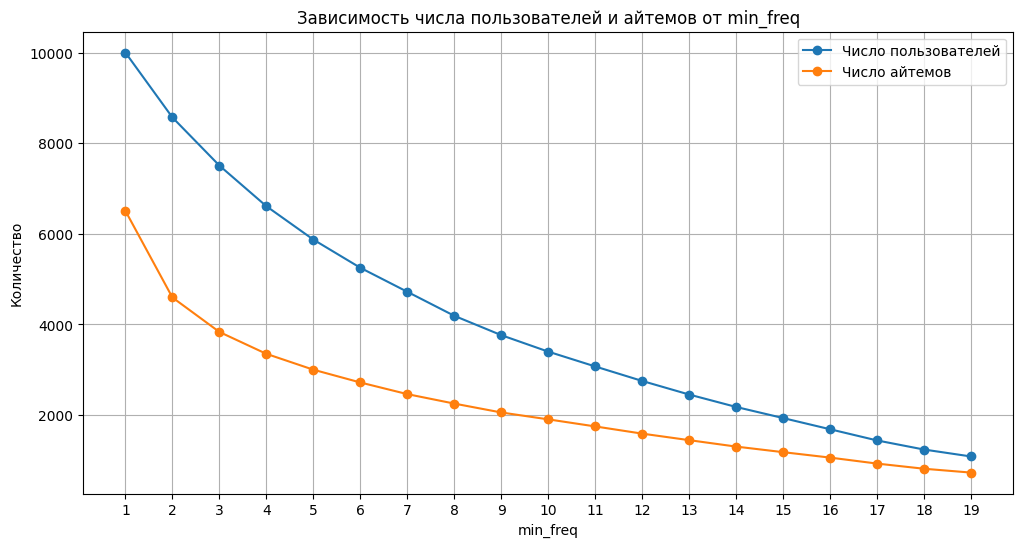

In [ ]:
min_freq_values = range(1, 20)
user_counts = []
item_counts = []

for min_freq in min_freq_values:
    filtered_train_plot = filter_dataframe(train_df, cols=['user_id', 'item_id'], min_freq=min_freq)
    filtered_train_plot, _, _, _, _ = df_encode(filtered_train_plot)

    user_counts.append(filtered_train_plot['user_id'].nunique())
    item_counts.append(filtered_train_plot['item_id'].nunique())


plt.figure(figsize=(12, 6))
plt.plot(min_freq_values, user_counts, marker='o', label='Число пользователей')
plt.plot(min_freq_values, item_counts, marker='o', label='Число айтемов')
plt.title('Зависимость числа пользователей и айтемов от min_freq')
plt.xlabel('min_freq')
plt.ylabel('Количество')
plt.xticks(min_freq_values)
plt.legend()
plt.grid()
plt.show()

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k.

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [ ]:
%%time

# Обучаем конечную модель
# Мы взяли реализацию из RecBole
#
def fit_ease(X, reg_weight=100):

    # gram matrix
    G = X.T @ X

    # add reg to diagonal
    G += reg_weight * sps.identity(G.shape[0])

    # convert to dense because inverse will be dense
    G = G.todense()

    # invert. this takes most of the time
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    # zero out diag
    np.fill_diagonal(B, 0.)

    return B

w = fit_ease(matrix)

CPU times: user 3.3 s, sys: 200 ms, total: 3.5 s
Wall time: 1.92 s


In [ ]:
w.shape

(3001, 3001)

Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [ ]:
def get_preds(x, item2id, id2item, topk=100, w=w):

    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]

    # Составляем вектор интеракций человека
    vector = np.zeros(len(item2id))
    vector[encoded] = 1

    vector = sps.csr_matrix(vector)

    preds = np.array(vector.dot(w))[0]#.toarray()
    preds[encoded==1] = -np.inf

    ranks = np.argsort(-preds)
    decoded = [id2item[t] for t in ranks][:topk]

    return decoded


joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,TopPopularWeighted_recs,toppopweighted_recs,ease_preds
0,165,"[(12173, 122)]","[(4969, 161)]","[10639, 16448, 1988]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 7793, 341, 13865, 12192, ...","[10440, 15297, 9728, 13865, 3734, 4151, 2657, ...","[7626, 10942, 8437, 5754, 682, 3734, 3784, 143..."
1,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ...","[(4651, 155), (15384, 155), (11099, 157), (633...","[10639, 16448, 1988]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 7793, 341, 13865, 12192, ...","[10440, 15297, 9728, 13865, 3734, 4151, 2657, ...","[10440, 9728, 13865, 15297, 12995, 9996, 4495,..."
2,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]","[10639, 16448, 1988]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 7793, 341, 13865, 12192, ...","[10440, 15297, 9728, 13865, 3734, 4151, 2657, ...","[9728, 15297, 2657, 13865, 3734, 7793, 12192, ..."
3,446,"[(13865, 105)]","[(12202, 160), (230, 160)]","[10639, 16448, 1988]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 7793, 341, 13865, 12192, ...","[10440, 15297, 9728, 13865, 3734, 4151, 2657, ...","[10440, 9728, 12995, 3734, 8636, 15297, 4740, ..."
4,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,...","[10639, 16448, 1988]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 7793, 341, 13865, 12192, ...","[10440, 15297, 9728, 13865, 3734, 4151, 2657, ...","[10440, 15297, 9728, 4151, 13865, 3734, 2657, ..."


In [ ]:
evaluate_recommender(joined, model_preds='ease_preds')

{'map': 0.07896826390760528, 'mrr': 0.13569968486154474, 'hr': 0.5641}

In [ ]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.0782833158490265, 'mrr': 0.13250313896223836, 'hr': 0.5665}

Сделайте выводы — какой алгоритм работает лучше?

**Ответ:** можно заметить, что показатели алгоритмов EASE и TopPop довольно схожи, однако алгоритм EASE демонстрирует немного более высокие результаты.

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации.

In [ ]:
%%time
regularization_values = np.linspace(0, 10000, 20)
map_ease, mrr_ease, hr_ease = [], [], []
df_params_search = joined.copy()

for reg_param in regularization_values:
    w = fit_ease(matrix, reg_weight=reg_param)
    df_params_search['ease_preds'] = df_params_search.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, w=w))

    metrics_ease = evaluate_recommender(df_params_search, model_preds='ease_preds')
    print(reg_param)
    print(metrics_ease)
    map_ease.append(metrics_ease['map'])
    mrr_ease.append(metrics_ease['mrr'])
    hr_ease.append(metrics_ease['hr'])

0.0
{'map': 0.05199650465521129, 'mrr': 0.08559365650172983, 'hr': 0.4617}
526.3157894736842
{'map': 0.08735544977742263, 'mrr': 0.15107585710118257, 'hr': 0.5954}
1052.6315789473683
{'map': 0.08984439004348495, 'mrr': 0.15570261583008224, 'hr': 0.6031}
1578.9473684210525
{'map': 0.09133881652290098, 'mrr': 0.15848120901838889, 'hr': 0.605}
2105.2631578947367
{'map': 0.0925093335546591, 'mrr': 0.16043020364350136, 'hr': 0.6063}
2631.578947368421
{'map': 0.09300675646788986, 'mrr': 0.16151297749480895, 'hr': 0.6077}
3157.894736842105
{'map': 0.09349414634066962, 'mrr': 0.16228805287253775, 'hr': 0.6075}
3684.210526315789
{'map': 0.09389952692670475, 'mrr': 0.16286901372807894, 'hr': 0.6066}
4210.526315789473
{'map': 0.09430400940800651, 'mrr': 0.16368107089367076, 'hr': 0.6063}
4736.8421052631575
{'map': 0.09452262302886297, 'mrr': 0.16392504874963715, 'hr': 0.6077}
5263.157894736842
{'map': 0.09469639018910715, 'mrr': 0.16431570143468946, 'hr': 0.6069}
5789.473684210526
{'map': 0.09492

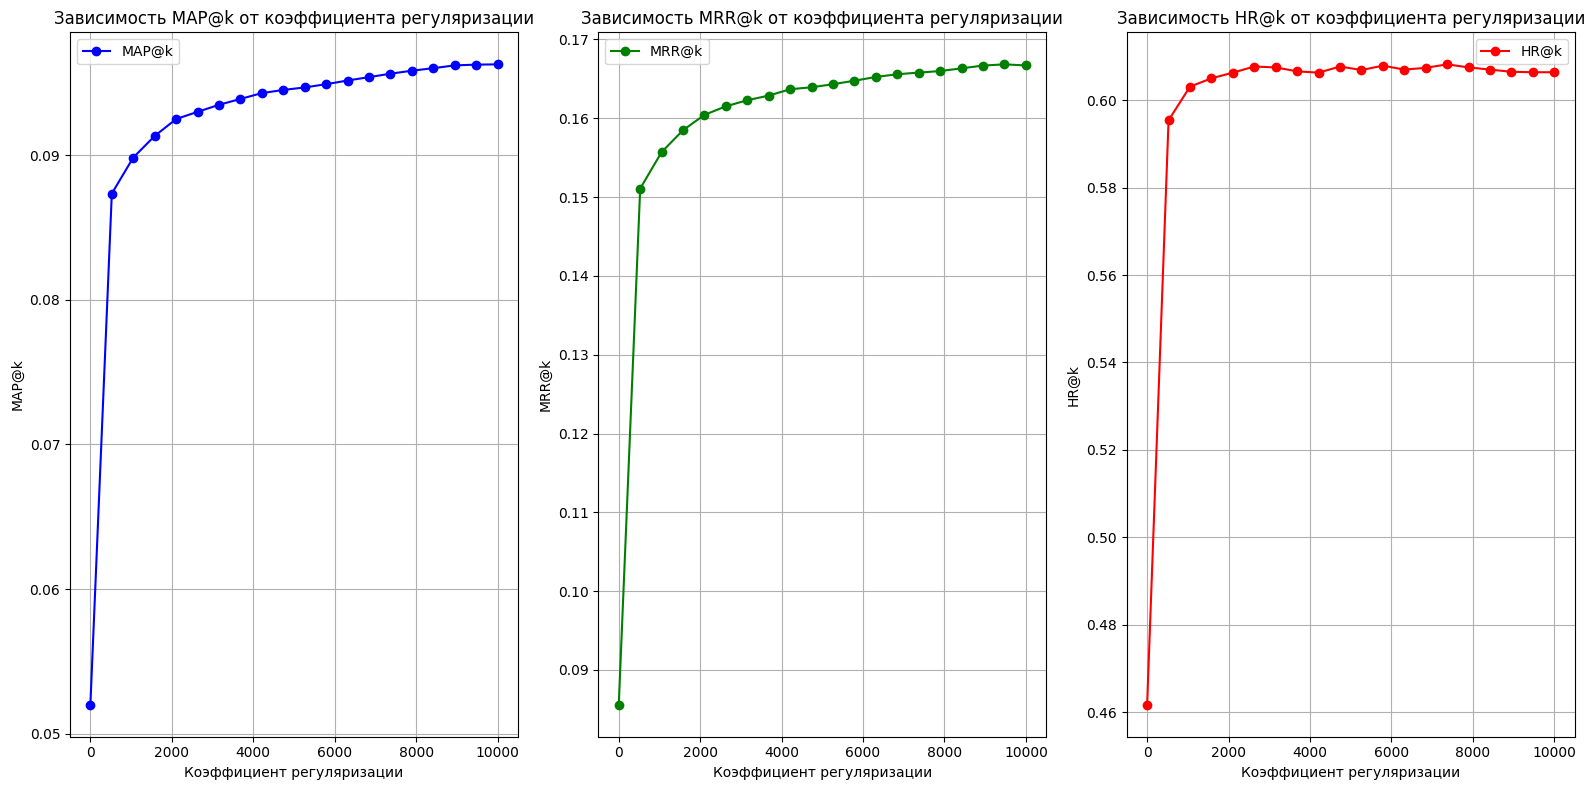

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8))
x = regularization_values.copy()

axs[0].plot(x, map_ease, color='b', marker='o', linestyle='-', label='MAP@k')
axs[0].set_title('Зависимость MAP@k от коэффициента регуляризации')
axs[0].set_xlabel('Коэффициент регуляризации')
axs[0].set_ylabel('MAP@k')
axs[0].legend()
axs[0].grid()

axs[1].plot(x, mrr_ease, color='g', marker='o', linestyle='-', label='MRR@k')
axs[1].set_title('Зависимость MRR@k от коэффициента регуляризации')
axs[1].set_xlabel('Коэффициент регуляризации')
axs[1].set_ylabel('MRR@k')
axs[1].legend()
axs[1].grid()

axs[2].plot(x, hr_ease, color='r', marker='o', linestyle='-', label='HR@k')
axs[2].set_title('Зависимость HR@k от коэффициента регуляризации')
axs[2].set_xlabel('Коэффициент регуляризации')
axs[2].set_ylabel('HR@k')
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()

Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим?


**Ответ:** трудно определить оптимальное значение гиперпараметра, так как график метрики HR@k показывает, что после значения коэффициента регуляризации примерно 3000 метрика немного снижается, а затем колеблется, периодически поднимаясь и опускаясь. Остальные метрики демонстрируют небольшой рост после значения 4000.

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:** можно сделать вывод, что метрики ведут себя похожим образом, но HR@k указывает на отсутствие необходимости увеличивать значение коэффициента регуляризации после 3000, поскольку дальнейшие изменения в рекомендациях будут незначительными.

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы.

In [ ]:
%%time
joined_topk = joined.copy()
map_ease_metrics, mrr_ease_metrics, hr_ease_metrics = [], [], []

min_freq_values = [4, 8, 12, 16, 20]

for min_freq in min_freq_values:
    filtered_train_freq = filter_dataframe(train_df, cols=['user_id', 'item_id'], min_freq=min_freq)
    filtered_train_freq, item2id_freq, user2id_freq, id2item_freq, id2user_freq = df_encode(filtered_train_freq)

    matrix_freq = sps.coo_matrix(
    (np.ones(filtered_train_freq.shape[0]), (filtered_train_freq['user_id'], filtered_train_freq['item_id'])),
    shape=(len(user2id_freq), len(item2id_freq)),
    )

    w_freq = fit_ease(matrix_freq)


    for topk in range(1, 101, 5):

        joined_topk['ease_preds'] = joined_topk.train_interactions.apply(lambda x: get_preds(x, item2id_freq, id2item_freq, topk=topk, w=w_freq))

        metrics_freq = evaluate_recommender(joined_topk, model_preds='ease_preds')

        map_ease_metrics.append(metrics_freq['map'])
        mrr_ease_metrics.append(metrics_freq['mrr'])
        hr_ease_metrics.append(metrics_freq['hr'])

CPU times: user 12min 24s, sys: 5.01 s, total: 12min 29s
Wall time: 12min 39s


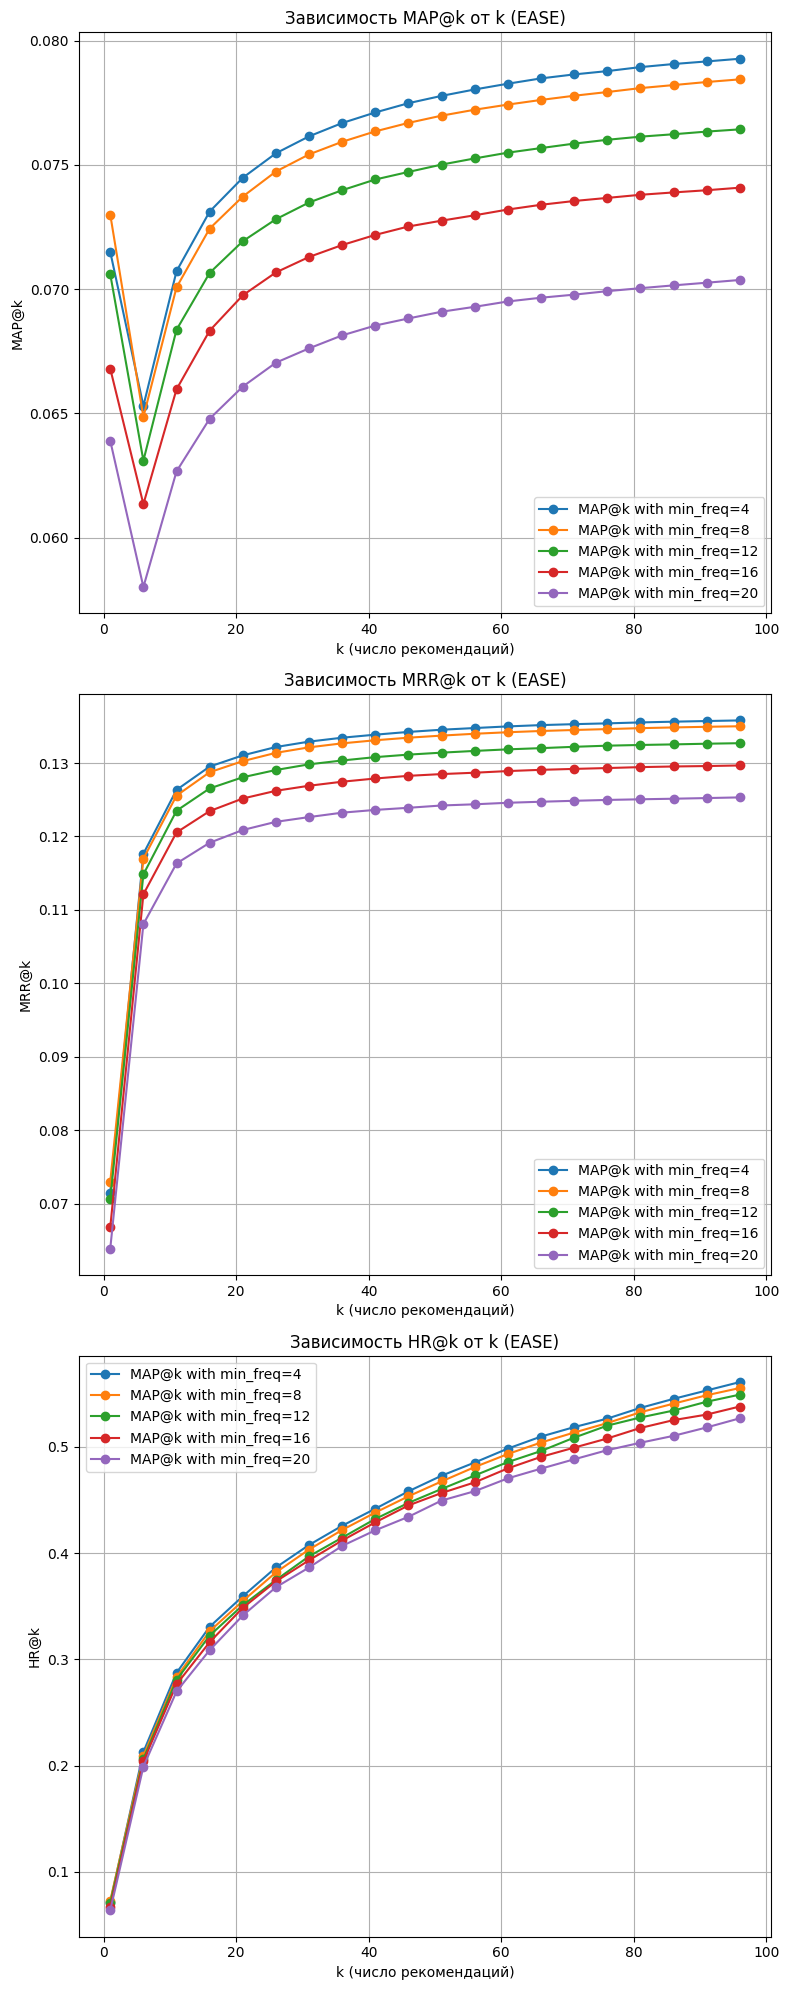

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 20))
topk_values = np.arange(1, 101, 5)

for curve in range(len(min_freq_values)):
    axs[0].plot(topk_values, map_ease_metrics[curve*len(topk_values):curve*len(topk_values)+len(topk_values)], marker='o', linestyle='-', label=f'MAP@k with min_freq={min_freq_values[curve]}')

axs[0].set_title('Зависимость MAP@k от k (EASE)')
axs[0].set_xlabel('k (число рекомендаций)')
axs[0].set_ylabel('MAP@k')
axs[0].legend()
axs[0].grid()


for curve in range(len(min_freq_values)):
    axs[1].plot(topk_values, mrr_ease_metrics[curve*len(topk_values):curve*len(topk_values)+len(topk_values)], marker='o', linestyle='-', label=f'MAP@k with min_freq={min_freq_values[curve]}')
axs[1].set_title('Зависимость MRR@k от k (EASE)')
axs[1].set_xlabel('k (число рекомендаций)')
axs[1].set_ylabel('MRR@k')
axs[1].legend()
axs[1].grid()

for curve in range(len(min_freq_values)):
    axs[2].plot(topk_values, hr_ease_metrics[curve*len(topk_values):curve*len(topk_values)+len(topk_values)], marker='o', linestyle='-', label=f'MAP@k with min_freq={min_freq_values[curve]}')
axs[2].set_title('Зависимость HR@k от k (EASE)')
axs[2].set_xlabel('k (число рекомендаций)')
axs[2].set_ylabel('HR@k')
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:** да, графики соответствуют моим ожиданиям. Ведут себя примерно одинаково, как в других пунктах домашки. Наблюдается только небольшая просадка у MAP@k для всех значений частоты встречаемости user/item. После этого значения все метрики монотонно растут. При этом мы видим, что чем больше значение k, тем меньше значение метрики для каждой частоты встречаемости.

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций.

In [ ]:
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


In [ ]:
matrix.shape

(5873, 3001)

In [ ]:
def get_topk_films(id, topk):
    top, index = 0, -1
    films=[]
    for film in matrix.todense()[id].tolist()[0]:
        index+=1
        if film == 1:
            top+=1
            films.append(index)
    films = films[:topk]

    recs_films = []
    for index in films:
        recs = items['title'].iloc[index]
        recs_films.append(recs)

    return recs_films, items['title'].iloc[id]

In [ ]:
import random

In [ ]:
topk=5
for i in range(10):
    rec_films, title_of_film = get_topk_films(id=random.randint(0, matrix.shape[0]), topk=topk)
    print(f'Топ-{topk} для фильма "{title_of_film}":')

    for film in rec_films:
        print(f'- {film}')

    print("\n")

Топ-5 для фильма "Лекарство для бабушки":
- Бладфест
- Назад в будущее. Часть 2
- Добро пожаловать в капкан
- Счастливый шанс
- Форсаж: Хоббс и Шоу


Топ-5 для фильма "Цена победы":
- Зорро
- Бронсон
- Сержант милиции
- Верь мне
- Счастливый шанс


Топ-5 для фильма "Форсаж 4":
- Марья-искусница
- Третья попытка
- Счастливый шанс
- Встреча с мечтой
- Час истины


Топ-5 для фильма "Мулен Руж":
- Третья попытка
- Клуб «Кастет»
- Крутые яйца
- Счастливый шанс
- Бойфренд на Рождество


Топ-5 для фильма "Пуля-дура":
- Марья-искусница
- Ангел
- В фокусе
- Хочу заняться любовью! 2
- Солнцекруг


Топ-5 для фильма "Быть Харви Вайнштейном":
- Здоровая спина
- Однажды в Ирландии
- Кружева
- Мальчишку звали Капитаном
- Римские приключения


Топ-5 для фильма "Великая иллюзия":
- Тайное окно
- Танцующая в темноте
- Сабрина (субтитры)
- Не бойся, я с тобой!
- Огненная Кэссиди


Топ-5 для фильма "Расходный материал":
- Марья-искусница
- Третья попытка
- Танцующая в темноте
- Йога для начинающих. Тренир

Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:** в целом, если я все правильно сделал, то получились средние, если не сказать плохие предсказания. Трудно по названию оценить правильно ли подбираются рекомендации, но иногда в топ-5 попадаются похожие по теме фильмы, так что это успех.

Например, попадаются следующие рекомендации для фильма "Судная ночь. Начало":

- Большая секунда,
- Пересекая черту,
- [4k] Крестный отец 2,
- Маняшино озеро,
- Вольт.

Или например, топ-5 для фильма "Законный брак":
- Марья-искусница
- Третья попытка
- Скиф
- Однажды в пустыне
- Встреча с мечтой.

А следующие рекомендации не очень хорошо подходят фильму. Топ-5 для фильма "Форсаж 4":
- Марья-искусница
- Третья попытка
- Счастливый шанс
- Встреча с мечтой
- Час истины.

Почему такие средние результаты: возможно, что пользователями было проделано мало интеракций, а также за выбранный период были какие-то выбросы в данных и пользователи смотрели больше одни фильмы, чем другие.